# Faster R-CNN in Pytorch with Example

In [1]:
!git clone https://github.com/KoGaan45/faster-r-cnn.git

Cloning into 'faster-r-cnn'...
remote: Enumerating objects: 5185, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 5185 (delta 0), reused 5 (delta 0), pack-reused 5176
Receiving objects: 100% (5185/5185), 1.30 GiB | 32.20 MiB/s, done.


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Images

**Note:** The annotations should also contain the corresponding image path

In [ ]:
class ObjectDetectionDataset(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.

    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx

        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()

    def __len__(self):
        return self.img_data_all.size(dim=0)

    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]

    def get_data(self):
        img_data_all = []
        gt_idxs_all = []

        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)

        for i, img_path in enumerate(img_paths):

            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue

            # read and resize image
            img = io.imread(img_path)
            img = resize(img, self.img_size)

            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1).cuda()

            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes]).cuda()

            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)

        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)

        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0).cuda()

        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [ ]:
img_width = 640
img_height = 480
annotation_path = "data/annotations.xml"
image_dir = os.path.join("data", "images")
name2idx = {'pad':-1, 'starfish': 0, 'holothurian': 1, 'scallop': 2,'echinus': 3}
idx2name = {v:k for k, v in name2idx.items()}

#### Create Dataset and Dataloaders

In [ ]:
od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)

In [ ]:
od_dataloader = DataLoader(od_dataset, batch_size=2)

#### Grab a batch for demonstration

In [ ]:
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break

img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

### Display Images and Bounding Boxes

In [ ]:
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

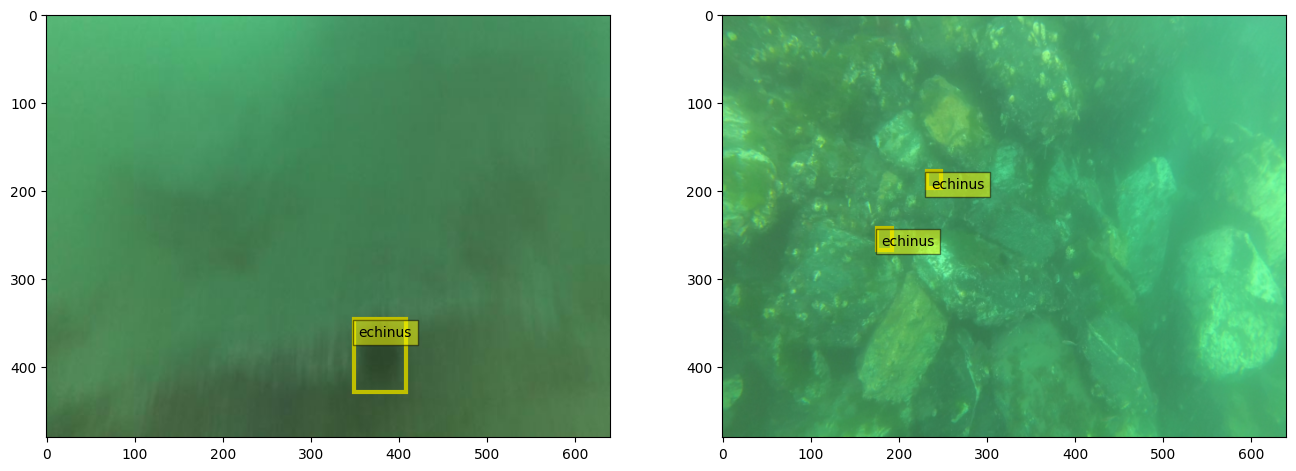

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all.cpu(), fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

## Convolutional Backbone Network

We will use the first 4 layers of resnet50 as our convolutional backbone

In [ ]:
model = torchvision.models.resnet50(pretrained=True).cuda()

In [ ]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [ ]:
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [ ]:
img_data_all = img_data_all

# run the image through the backbone
out = backbone(img_data_all)

In [ ]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [ ]:
out_c, out_h, out_w

(2048, 15, 20)

#### Check how much the image has been down-scaled

In [ ]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

### Visualize feature maps

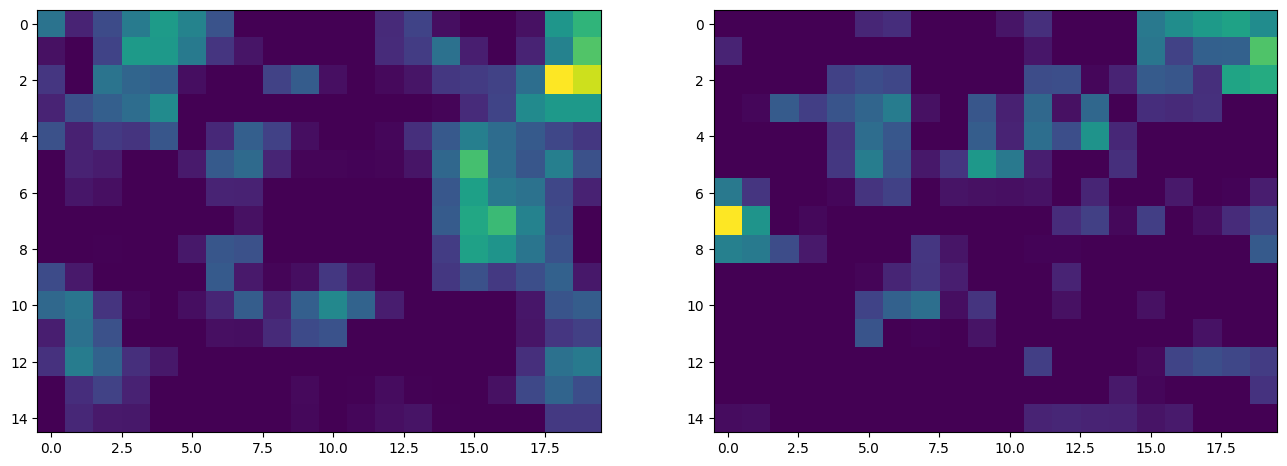

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data = [filters[0].detach().cpu().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

### Generate and Plot Anchor Points

In [ ]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

### Display Grid Mapping

In [ ]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

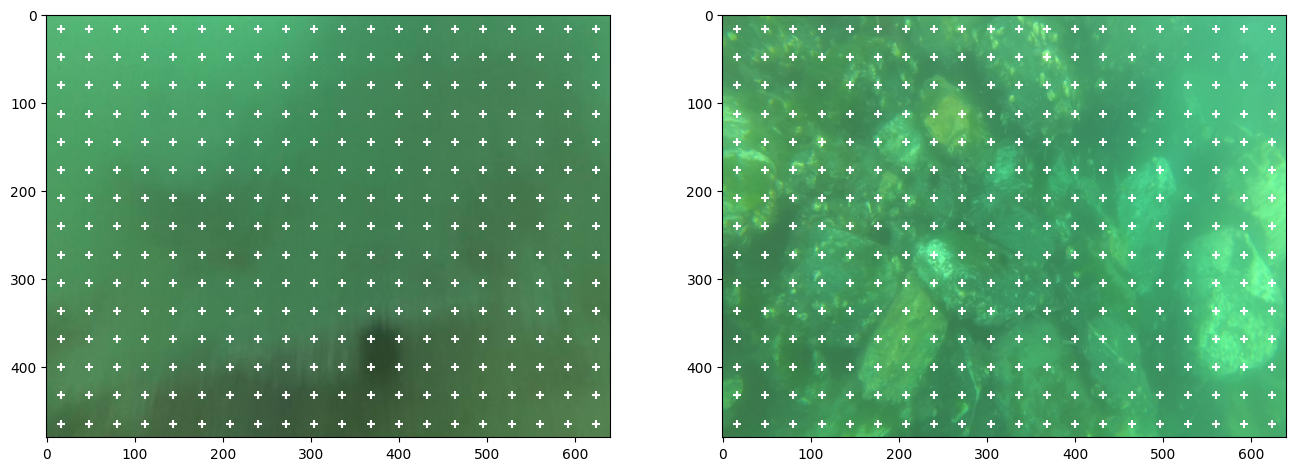

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all.cpu(), fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

### Create Anchor Boxes around Anchor points

In [ ]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [ ]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

### plot anchor boxes on a single anchor point

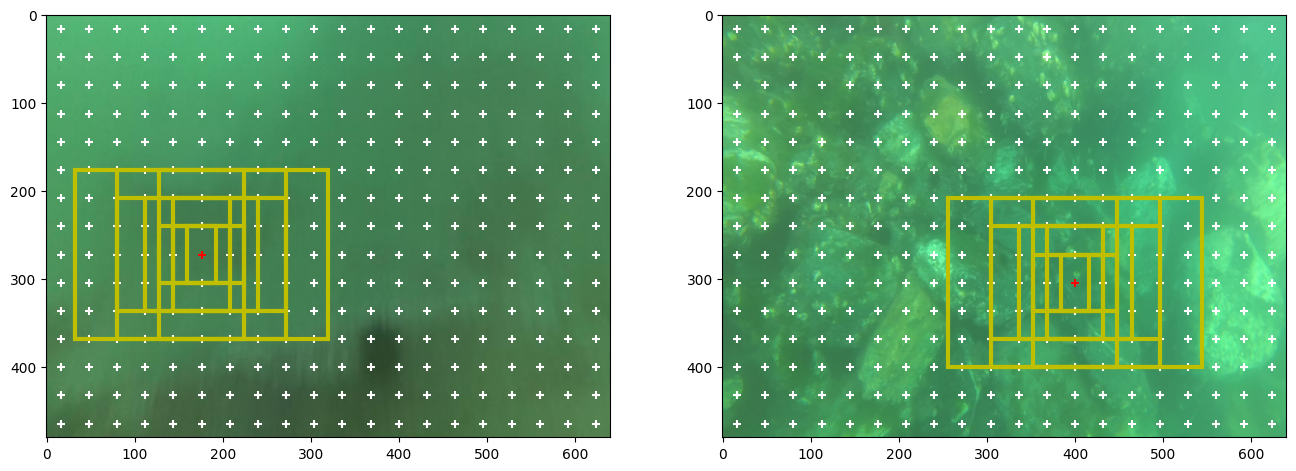

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all.cpu(), fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

### plot all anchor boxes

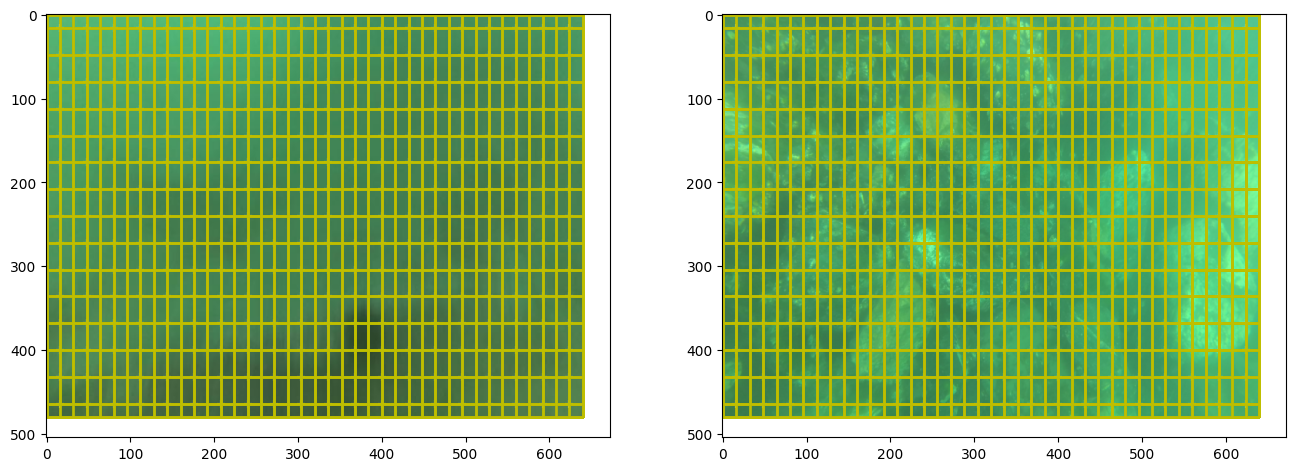

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all.cpu(), fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

### Get Positive and Negative Anchors

In [ ]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [ ]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

#### Visualize positive anchor coordinates

In [ ]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

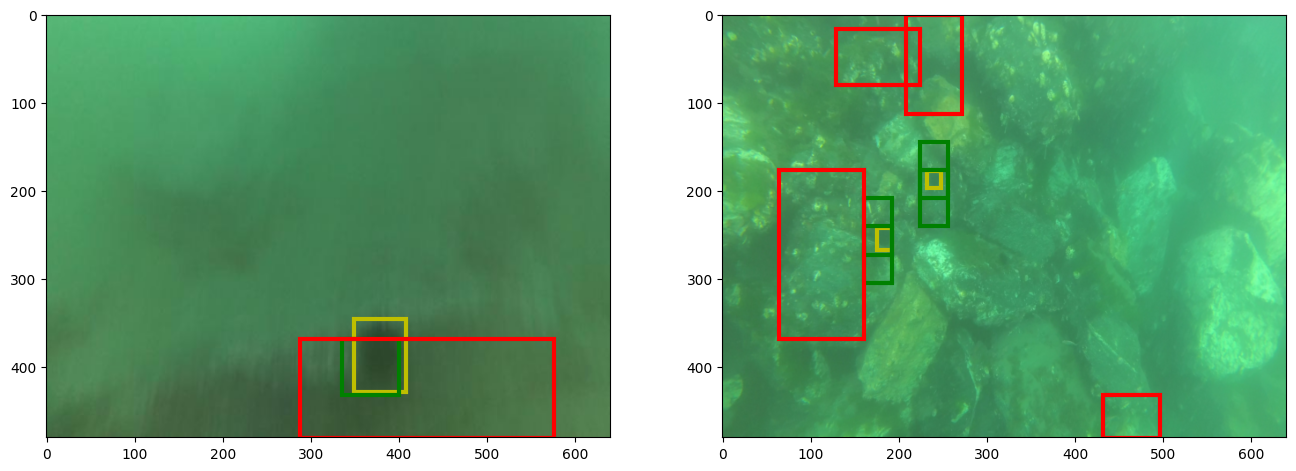

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all.cpu(), fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0].cpu(), fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1].cpu(), fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1.cpu(), fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2.cpu(), fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1.cpu(), fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2.cpu(), fig, axes[1], color='r')

### Building the model

In [ ]:
img_batch, gt_bboxes_batch, gt_classes_batch = img_batch.to(device, dtype=torch.float32), gt_bboxes_batch, gt_classes_batch

In [ ]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size).to(device)

In [ ]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

AttributeError: ignored

### Training loop

In [ ]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    loss_list = []

    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:

            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        loss_list.append(total_loss)

    return loss_list

In [ ]:
learning_rate = 1e-3
n_epochs = 1

loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

In [ ]:
plt.plot(loss_list)

#### save model

In [ ]:
torch.save(detector.state_dict(), "model.pt")

### Inference

In [ ]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.5, nms_thresh=0.05)

In [ ]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)